In [ ]:
# ======================================
# Malicious URL Detection with 3-Sieve Pipeline
# With Confusion Matrices + Metrics + Training Curves + Detailed Sieve-2 Evaluations
# ======================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score,
                             mean_squared_error, roc_auc_score)
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Bidirectional
from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer
import tensorflow as tf
from google.colab import files

# ===========================
# Helper Functions
# ===========================
def plot_confusion(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def evaluate_model(y_true, y_pred, labels, title):
    """
    Robust evaluator: if y_true is empty, returns nan metrics and prints notice.
    """
    if len(y_true) == 0:
        print(f"\n=== {title} ===")
        print("No samples to evaluate for this stage (empty set).")
        return {"Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan, "F1-score": np.nan, "MSE": np.nan, "RMSE": np.nan}

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"\n=== {title} ===")
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))
    plot_confusion(y_true, y_pred, labels, f"{title} Confusion Matrix")

    return {"Accuracy": acc, "Precision": prec, "Recall": rec,
            "F1-score": f1, "MSE": mse, "RMSE": rmse}

def plot_training_curves(history, title):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title(f"{title} - Accuracy vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{title} - Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

In [ ]:
# ===========================
# 1. Upload dataset
# ===========================
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

X = df["url"].astype(str)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Label encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)

Saving malicious_phish_CSV.csv to malicious_phish_CSV.csv



=== Sieve 1: Logistic Regression ===
              precision    recall  f1-score   support

      benign       0.99      1.00      0.99     68337
  defacement       0.99      1.00      1.00     16152
     malware       1.00      0.99      0.99      5340
    phishing       0.95      0.89      0.92      7828

    accuracy                           0.99     97657
   macro avg       0.98      0.97      0.98     97657
weighted avg       0.99      0.99      0.99     97657



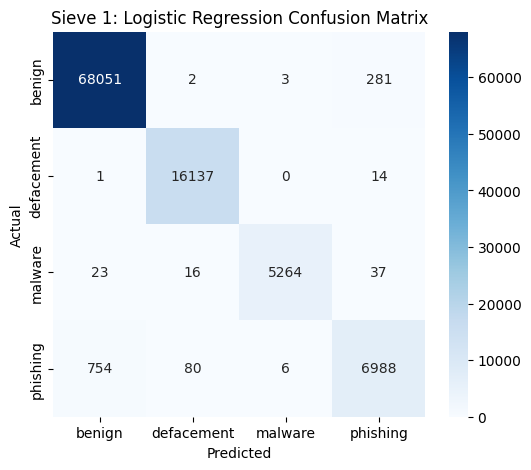

In [ ]:
# ===========================
# 2. Sieve 1 - Logistic Regression (TF-IDF)
# ===========================
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

log_reg = LogisticRegression(max_iter=200, solver="lbfgs")
log_reg.fit(X_train_tfidf, y_train_enc)

probs = log_reg.predict_proba(X_test_tfidf)
confidences = np.max(probs, axis=1)
preds_s1 = log_reg.predict(X_test_tfidf)

threshold = 0.9
accepted_idx = confidences >= threshold
remaining_idx = ~accepted_idx

# Evaluate Sieve 1 only on accepted samples (if any)
metrics_s1 = evaluate_model(
    y_test_enc[accepted_idx],
    preds_s1[accepted_idx],
    le.classes_,
    "Sieve 1: Logistic Regression"
)
acc_s1 = metrics_s1["Accuracy"]

# Remaining for Sieve 2
X_remaining = X_test.iloc[remaining_idx].reset_index(drop=True)
y_remaining = y_test.iloc[remaining_idx].reset_index(drop=True)
y_remaining_enc = le.transform(y_remaining)

In [ ]:
# ===========================
# 3. Prepare sequences for Sieve 2
# ===========================
max_words = 50000
max_len = 200

# Character-level tokenizer (you used char_level=True originally)
tokenizer = Tokenizer(num_words=max_words, char_level=True)
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)
X_remaining_seq = pad_sequences(tokenizer.texts_to_sequences(X_remaining), maxlen=max_len)

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)
y_remaining_cat = to_categorical(y_remaining_enc, num_classes=num_classes)

In [ ]:
# ===========================
# 4. Define Models
# ===========================
def build_cnn(max_words, max_len, num_classes):
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_lstm(max_words, max_len, num_classes):
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_bilstm(max_words, max_len, num_classes):
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 44s 19ms/step - accuracy: 0.8917 - loss: 0.3199 - val_accuracy: 0.9666 - val_loss: 0.1022
Epoch 2/3
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 65s 14ms/step - accuracy: 0.9628 - loss: 0.1215 - val_accuracy: 0.9733 - val_loss: 0.0855
Epoch 3/3
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9683 - loss: 0.1015 - val_accuracy: 0.9755 - val_loss: 0.0782


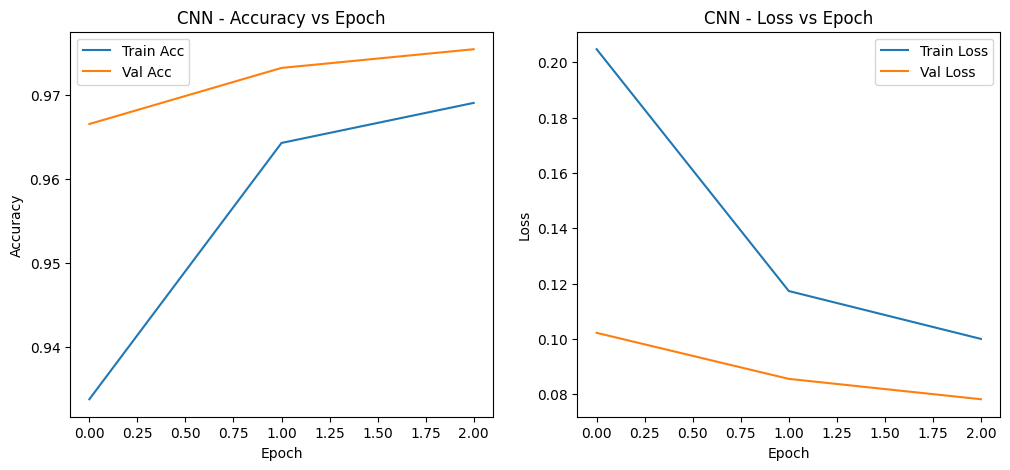

Epoch 1/3
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 1323s 717ms/step - accuracy: 0.8123 - loss: 0.5388 - val_accuracy: 0.9357 - val_loss: 0.1836
Epoch 2/3
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 1320s 721ms/step - accuracy: 0.9322 - loss: 0.2043 - val_accuracy: 0.9530 - val_loss: 0.1375
Epoch 3/3
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 1314s 705ms/step - accuracy: 0.9493 - loss: 0.1580 - val_accuracy: 0.9613 - val_loss: 0.1157


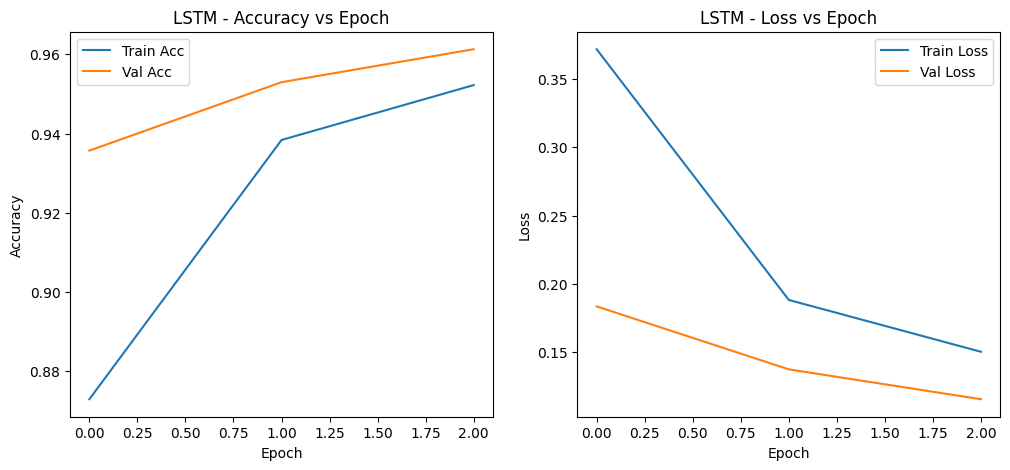

Epoch 1/3
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 2439s 1s/step - accuracy: 0.8231 - loss: 0.5126 - val_accuracy: 0.9324 - val_loss: 0.1946
Epoch 2/3
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 2507s 1s/step - accuracy: 0.9308 - loss: 0.2114 - val_accuracy: 0.9509 - val_loss: 0.1452
Epoch 3/3
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 2402s 1s/step - accuracy: 0.9501 - loss: 0.1562 - val_accuracy: 0.9606 - val_loss: 0.1163


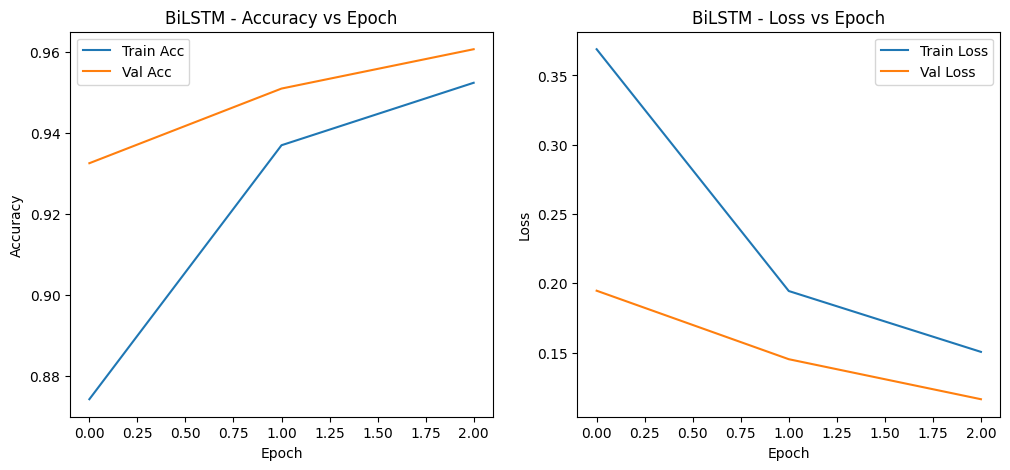

In [ ]:
# ===========================
# 5. Train CNN, LSTM, BiLSTM
# ===========================
cnn = build_cnn(max_words, max_len, num_classes)
cnn_history = cnn.fit(X_train_seq, y_train_cat, epochs=3, batch_size=256,
                      validation_split=0.1, verbose=1)
plot_training_curves(cnn_history, "CNN")

lstm = build_lstm(max_words, max_len, num_classes)
lstm_history = lstm.fit(X_train_seq, y_train_cat, epochs=3, batch_size=256,
                        validation_split=0.1, verbose=1)
plot_training_curves(lstm_history, "LSTM")

bilstm = build_bilstm(max_words, max_len, num_classes)
bilstm_history = bilstm.fit(X_train_seq, y_train_cat, epochs=3, batch_size=256,
                            validation_split=0.1, verbose=1)
plot_training_curves(bilstm_history, "BiLSTM")

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 120s 118ms/step
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 231s 226ms/step

=== Sieve 2: Voting (CNN+LSTM+BiLSTM) ===
              precision    recall  f1-score   support

      benign       0.91      0.97      0.94     17284
  defacement       0.90      0.97      0.93      3140
     malware       0.92      0.58      0.71      1164
    phishing       0.92      0.85      0.88     10994

    accuracy                           0.91     32582
   macro avg       0.91      0.84      0.87     32582
weighted avg       0.91      0.91      0.91     32582



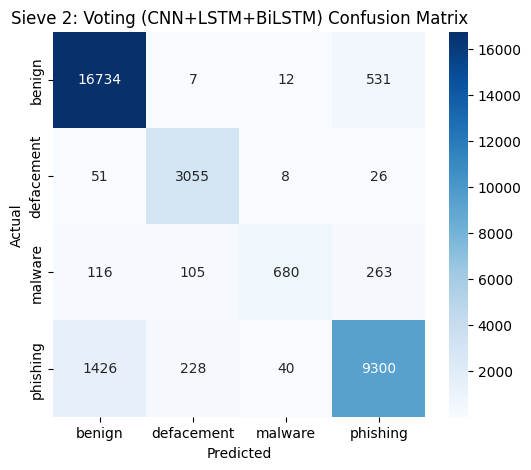

In [ ]:
# ===========================
# 6. Predictions + Voting in Sieve 2
# ===========================
# Predict on remaining sequences
cnn_preds = np.argmax(cnn.predict(X_remaining_seq), axis=1)
lstm_preds = np.argmax(lstm.predict(X_remaining_seq), axis=1)
bilstm_preds = np.argmax(bilstm.predict(X_remaining_seq), axis=1)

stacked_preds = np.vstack([cnn_preds, lstm_preds, bilstm_preds])
votes = np.apply_along_axis(lambda x: np.bincount(x, minlength=num_classes).argmax(),
                            axis=0, arr=stacked_preds)

metrics_s2 = evaluate_model(y_remaining_enc, votes, le.classes_, "Sieve 2: Voting (CNN+LSTM+BiLSTM)")
acc_s2 = metrics_s2["Accuracy"]

# Remaining for Sieve 3
# Try to forward only non-benign to BERT if class 'benign' exists, else forward all non-agreed samples
if "benign" in list(le.classes_):
    benign_label_enc = le.transform(["benign"])[0]
    hard_idx = votes != benign_label_enc
else:
    # If 'benign' not present assume forward everything that is disagreed or non-majority?
    hard_idx = np.ones_like(votes, dtype=bool)

X_hard = X_remaining.iloc[hard_idx].reset_index(drop=True)
y_hard = y_remaining.iloc[hard_idx].reset_index(drop=True)
y_hard_enc = le.transform(y_hard)

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

=== Sieve 2 - CNN ===
              precision    recall  f1-score   support

      benign       0.95      0.96      0.96     17284
  defacement       0.94      0.98      0.96      3140
     malware       0.90      0.71      0.80      1164
    phishing       0.92      0.90      0.91     10994

    accuracy                           0.93     32582
   macro avg       0.93      0.89      0.90     32582
weighted avg       0.93      0.93      0.93     32582



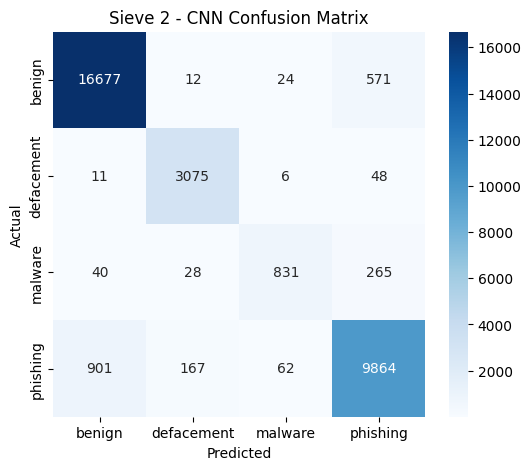

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 123s 121ms/step

=== Sieve 2 - LSTM ===
              precision    recall  f1-score   support

      benign       0.91      0.96      0.93     17284
  defacement       0.89      0.95      0.92      3140
     malware       0.88      0.53      0.66      1164
    phishing       0.91      0.84      0.87     10994

    accuracy                           0.90     32582
   macro avg       0.90      0.82      0.85     32582
weighted avg       0.90      0.90      0.90     32582



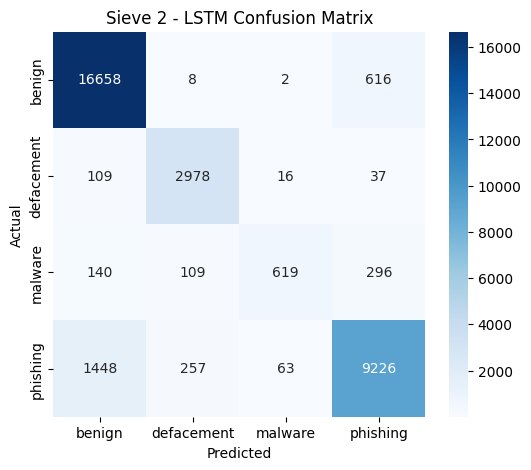

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 234s 230ms/step

=== Sieve 2 - BiLSTM ===
              precision    recall  f1-score   support

      benign       0.90      0.96      0.93     17284
  defacement       0.86      0.97      0.91      3140
     malware       0.85      0.56      0.68      1164
    phishing       0.91      0.81      0.86     10994

    accuracy                           0.90     32582
   macro avg       0.88      0.83      0.84     32582
weighted avg       0.90      0.90      0.90     32582



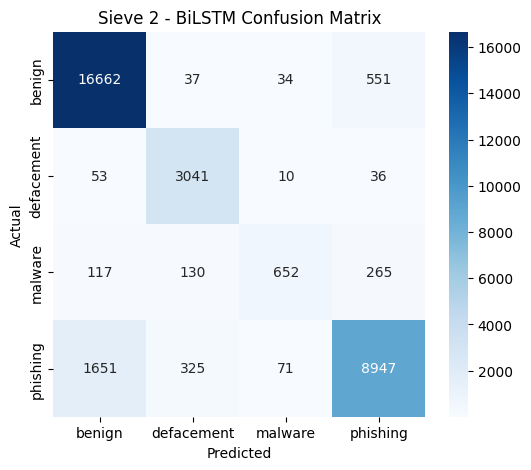

In [ ]:
# ===========================
# Evaluate individual models in Sieve 2
# ===========================

# CNN
cnn_preds_full = np.argmax(cnn.predict(X_remaining_seq), axis=1)
metrics_cnn = evaluate_model(
    y_remaining_enc, cnn_preds_full, le.classes_, "Sieve 2 - CNN"
)

# LSTM
lstm_preds_full = np.argmax(lstm.predict(X_remaining_seq), axis=1)
metrics_lstm = evaluate_model(
    y_remaining_enc, lstm_preds_full, le.classes_, "Sieve 2 - LSTM"
)

# BiLSTM
bilstm_preds_full = np.argmax(bilstm.predict(X_remaining_seq), axis=1)
metrics_bilstm = evaluate_model(
    y_remaining_enc, bilstm_preds_full, le.classes_, "Sieve 2 - BiLSTM"
)

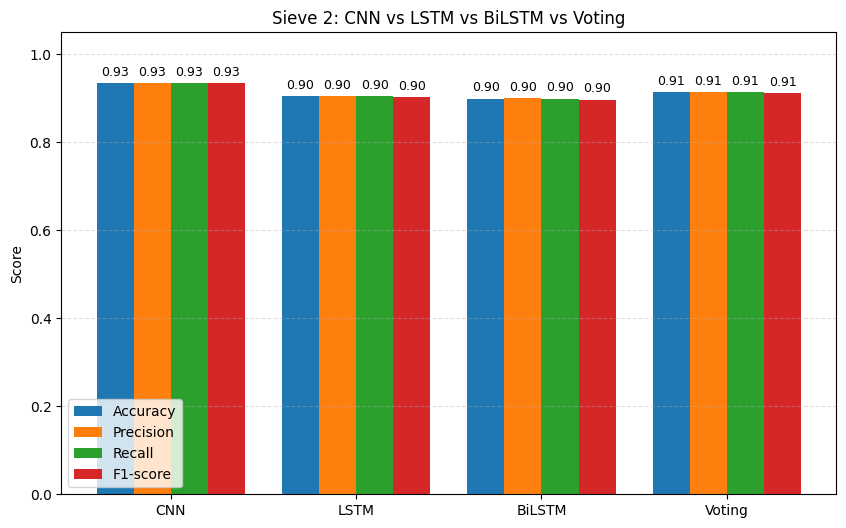

In [ ]:
# ===========================
# Comparison chart: Sieve 2 models vs Voting
# ===========================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Gather metrics
sieve2_models = ["CNN", "LSTM", "BiLSTM", "Voting"]
accuracy = [
    metrics_cnn["Accuracy"],
    metrics_lstm["Accuracy"],
    metrics_bilstm["Accuracy"],
    metrics_s2["Accuracy"]   # ensemble voting
]
precision = [
    metrics_cnn["Precision"],
    metrics_lstm["Precision"],
    metrics_bilstm["Precision"],
    metrics_s2["Precision"]
]
recall = [
    metrics_cnn["Recall"],
    metrics_lstm["Recall"],
    metrics_bilstm["Recall"],
    metrics_s2["Recall"]
]
f1 = [
    metrics_cnn["F1-score"],
    metrics_lstm["F1-score"],
    metrics_bilstm["F1-score"],
    metrics_s2["F1-score"]
]

# Create DataFrame for convenience
df_compare = pd.DataFrame({
    "Model": sieve2_models,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1": f1
})

# Plot grouped bar chart
x = np.arange(len(sieve2_models))
width = 0.2

plt.figure(figsize=(10,6))
bars1 = plt.bar(x - 1.5*width, df_compare["Accuracy"], width, label="Accuracy")
bars2 = plt.bar(x - 0.5*width, df_compare["Precision"], width, label="Precision")
bars3 = plt.bar(x + 0.5*width, df_compare["Recall"], width, label="Recall")
bars4 = plt.bar(x + 1.5*width, df_compare["F1"], width, label="F1-score")

plt.xticks(x, sieve2_models)
plt.ylim(0,1.05)
plt.ylabel("Score")
plt.title("Sieve 2: CNN vs LSTM vs BiLSTM vs Voting")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Annotate bars with values
for bars in [bars1, bars2, bars3, bars4]:
    for b in bars:
        h = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, h + 0.01,
                 f"{h:.2f}", ha="center", va="bottom", fontsize=9)

plt.show()

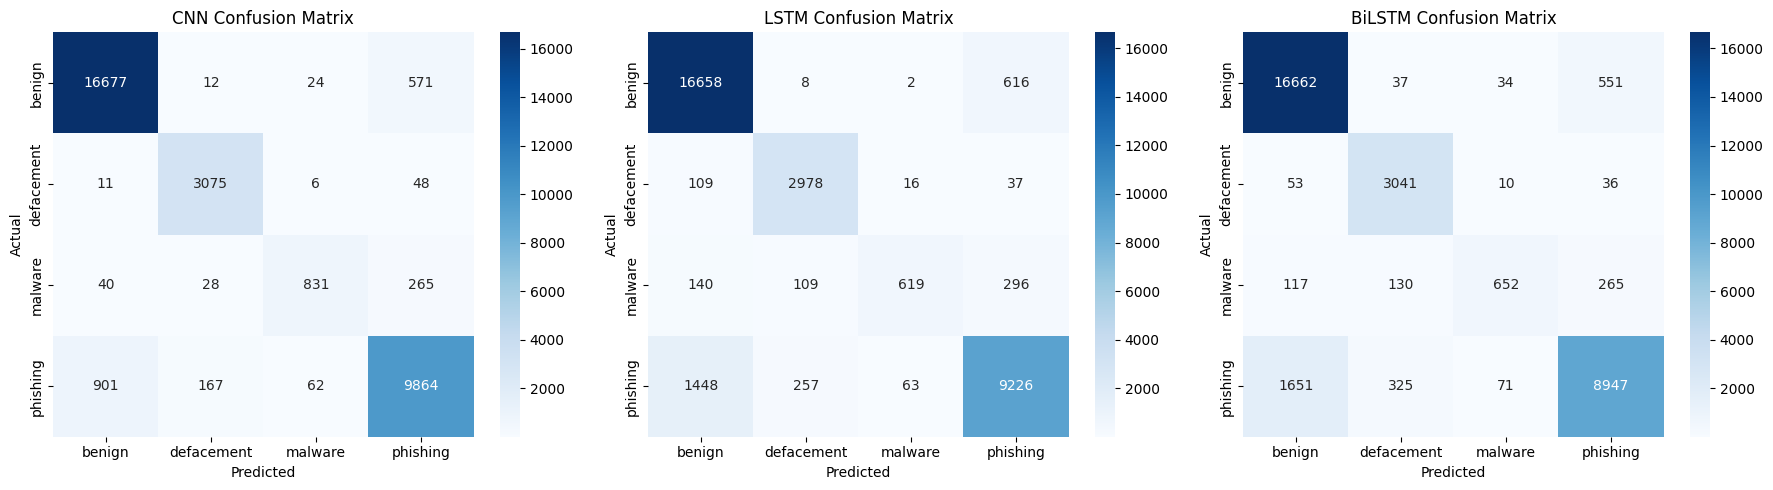

In [ ]:
# ===========================
# Sieve 2: Compare confusion matrices side by side
# ===========================
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

models = ["CNN", "LSTM", "BiLSTM"]
preds_list = [cnn_preds_full, lstm_preds_full, bilstm_preds_full]

plt.figure(figsize=(18,5))

for i, (model_name, preds) in enumerate(zip(models, preds_list)):
    cm = confusion_matrix(y_remaining_enc, preds)
    plt.subplot(1, 3, i+1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

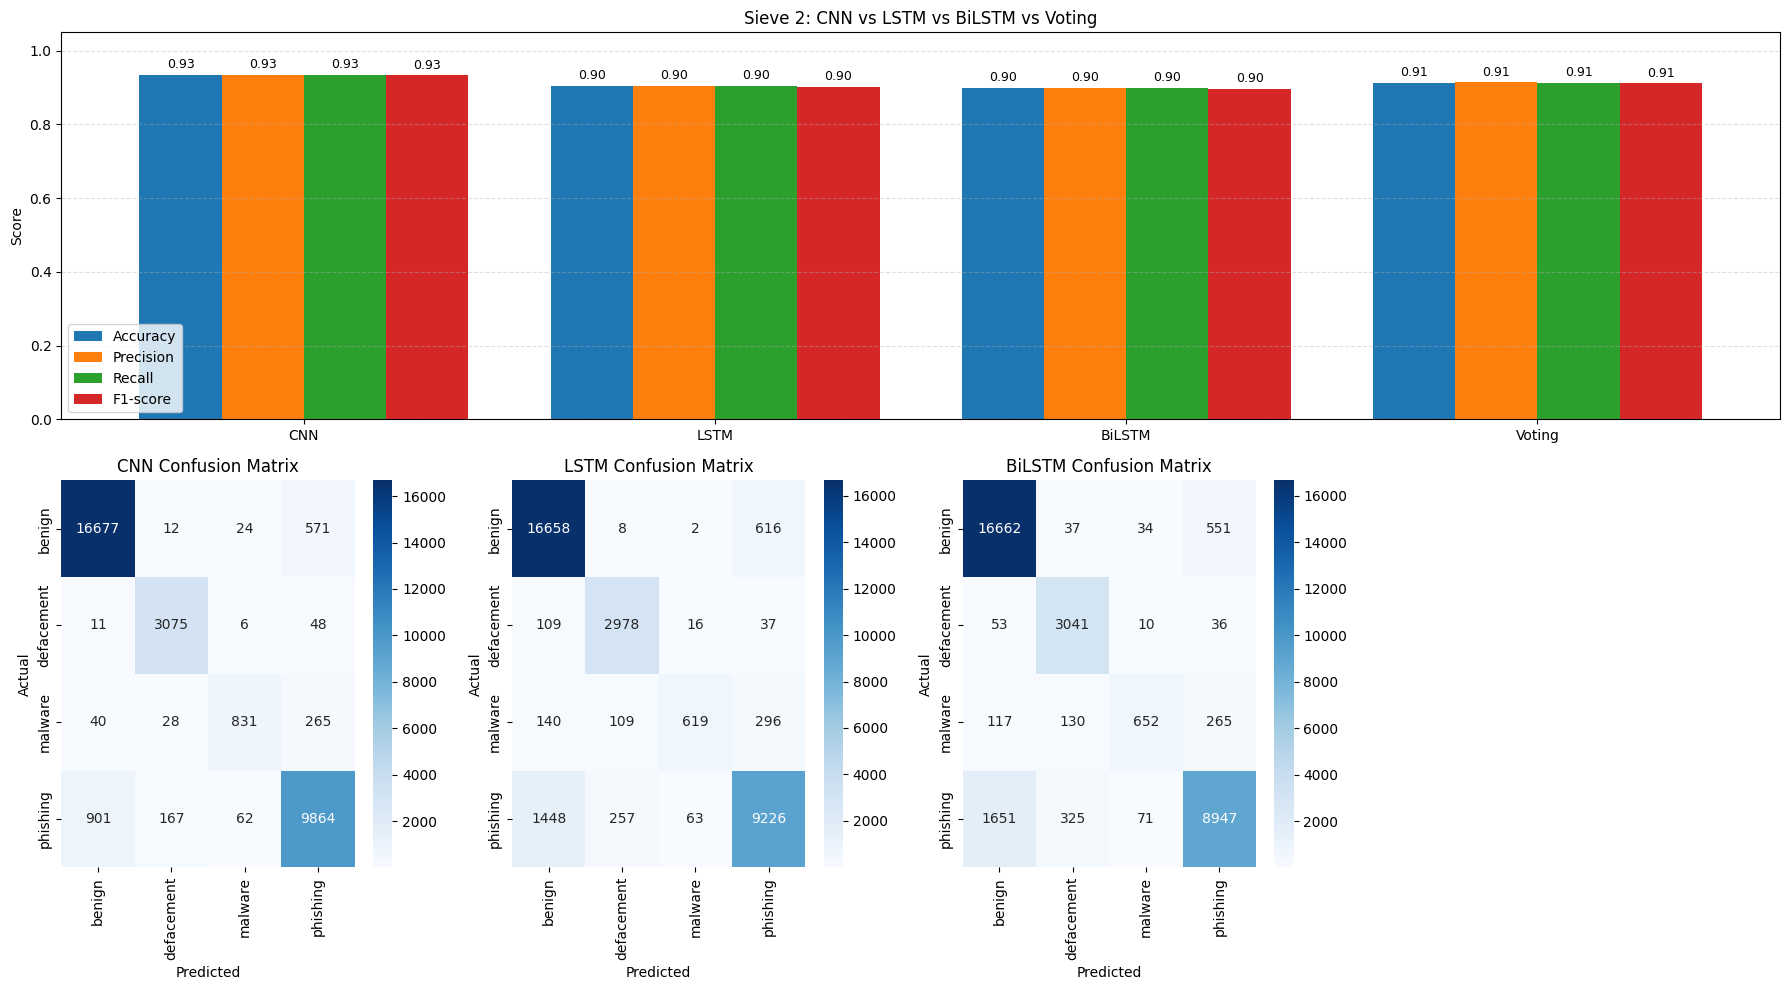

In [ ]:
# ===========================
# Sieve 2: Combined Metrics + Confusion Matrices
# ===========================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# --- Prepare metrics ---
sieve2_models = ["CNN", "LSTM", "BiLSTM", "Voting"]
accuracy = [
    metrics_cnn["Accuracy"],
    metrics_lstm["Accuracy"],
    metrics_bilstm["Accuracy"],
    metrics_s2["Accuracy"]   # ensemble voting
]
precision = [
    metrics_cnn["Precision"],
    metrics_lstm["Precision"],
    metrics_bilstm["Precision"],
    metrics_s2["Precision"]
]
recall = [
    metrics_cnn["Recall"],
    metrics_lstm["Recall"],
    metrics_bilstm["Recall"],
    metrics_s2["Recall"]
]
f1 = [
    metrics_cnn["F1-score"],
    metrics_lstm["F1-score"],
    metrics_bilstm["F1-score"],
    metrics_s2["F1-score"]
]

df_metrics = pd.DataFrame({
    "Model": sieve2_models,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1": f1
})

# --- Prepare confusion matrices ---
models_cm = ["CNN", "LSTM", "BiLSTM"]
preds_list = [cnn_preds_full, lstm_preds_full, bilstm_preds_full]
cms = [confusion_matrix(y_remaining_enc, preds) for preds in preds_list]

# --- Plot combined figure ---
fig = plt.figure(figsize=(18,10))

# 1. Grouped bar chart
ax1 = plt.subplot2grid((2,4), (0,0), colspan=4)
x = np.arange(len(sieve2_models))
width = 0.2

bars1 = ax1.bar(x - 1.5*width, df_metrics["Accuracy"], width, label="Accuracy")
bars2 = ax1.bar(x - 0.5*width, df_metrics["Precision"], width, label="Precision")
bars3 = ax1.bar(x + 0.5*width, df_metrics["Recall"], width, label="Recall")
bars4 = ax1.bar(x + 1.5*width, df_metrics["F1"], width, label="F1-score")

ax1.set_xticks(x)
ax1.set_xticklabels(sieve2_models)
ax1.set_ylim(0,1.05)
ax1.set_ylabel("Score")
ax1.set_title("Sieve 2: CNN vs LSTM vs BiLSTM vs Voting")
ax1.legend()
ax1.grid(axis="y", linestyle="--", alpha=0.4)

# Annotate bars
for bars in [bars1, bars2, bars3, bars4]:
    for b in bars:
        h = b.get_height()
        ax1.text(b.get_x() + b.get_width()/2, h + 0.01, f"{h:.2f}", ha="center", va="bottom", fontsize=9)

# 2. Confusion matrices
for i, (cm, model_name) in enumerate(zip(cms, models_cm)):
    ax = plt.subplot2grid((2,4), (1,i))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
    ax.set_title(f"{model_name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should p

Epoch 1/2
32560/32560 [==============================] - 551s 17ms/step - loss: 0.1264 - accuracy: 0.9599
Epoch 2/2
446/446 [==============================] - 4s 8ms/step

=== Sieve 3: TinyBERT ===
              precision    recall  f1-score   support

      benign       0.76      0.63      0.69       550
  defacement       0.97      0.98      0.97      3089
     malware       0.95      0.77      0.85      1048
    phishing       0.95      0.97      0.96      9568

    accuracy                           0.95     14255
   macro avg       0.91      0.84      0.87     14255
weighted avg       0.95      0.95      0.95     14255



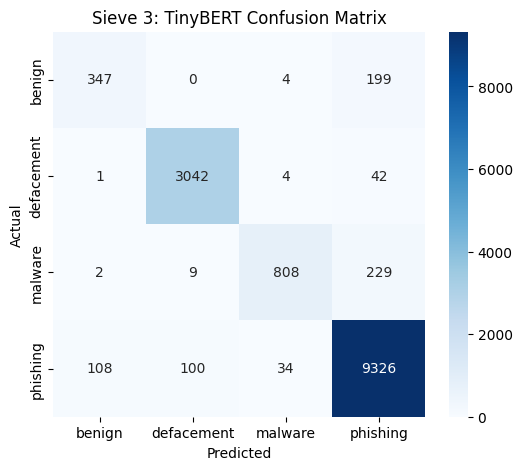

In [ ]:
# ===========================
# 7. Sieve 3 - TinyBERT
# ===========================
bert_model_name = "prajjwal1/bert-tiny"
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)

train_encodings = bert_tokenizer(list(X_train), truncation=True, padding=True,
                                 max_length=128, return_tensors="tf")
test_encodings = bert_tokenizer(list(X_hard), truncation=True, padding=True,
                                max_length=128, return_tensors="tf")

bert_model = TFBertForSequenceClassification.from_pretrained(
    bert_model_name, num_labels=num_classes, from_pt=True
)

batch_size = 16
num_train_steps = int(len(X_train) / batch_size * 2)  # 2 epochs
optimizer, lr_schedule = create_optimizer(init_lr=5e-5, num_warmup_steps=0,
                                          num_train_steps=num_train_steps)

bert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

bert_model.fit(train_encodings["input_ids"], y_train_enc,
               epochs=2, batch_size=batch_size, verbose=1)

# If there are no hard examples, skip predict
if len(X_hard) > 0:
    bert_preds = np.argmax(bert_model.predict(test_encodings["input_ids"]).logits, axis=1)
else:
    bert_preds = np.array([], dtype=int)

metrics_s3 = evaluate_model(y_hard_enc, bert_preds, le.classes_, "Sieve 3: TinyBERT")
acc_s3 = metrics_s3["Accuracy"]


=== Final Pipeline ===
              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.99      0.99      0.99     19292
     malware       0.99      0.93      0.96      6504
    phishing       0.95      0.87      0.91     18822

    accuracy                           0.97    130239
   macro avg       0.98      0.95      0.96    130239
weighted avg       0.97      0.97      0.97    130239



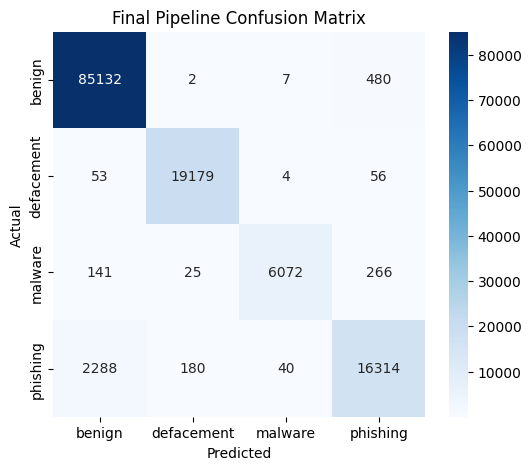

In [ ]:
# ===========================
# 8. Final Pipeline Metrics
# ===========================
# Start with Sieve 1 predictions for all test samples
final_preds = preds_s1.copy()

# Map remaining votes into final preds
remaining_indices = np.where(remaining_idx)[0]  # indices into X_test
# Put votes (predictions for the remaining set) into corresponding positions
final_preds[remaining_indices] = votes

# Now override hard indices with bert predictions (if any)
if len(bert_preds) > 0:
    hard_indices = remaining_indices[hard_idx]
    final_preds[hard_indices] = bert_preds

metrics_final = evaluate_model(y_test_enc, final_preds, le.classes_, "Final Pipeline")
acc_final = metrics_final["Accuracy"]

/tmp/ipython-input-426754486.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Sieve 1", "Sieve 2", "Sieve 3", "Final"],


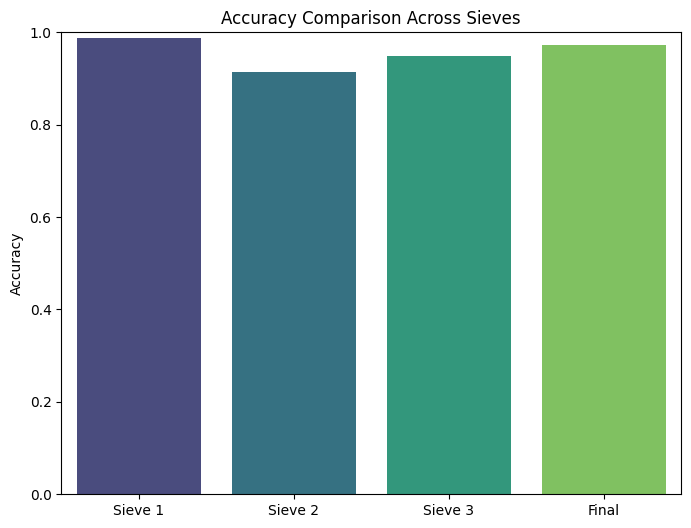

In [ ]:
# ===========================
# 9. Accuracy Comparison Bar Chart
# ===========================
plt.figure(figsize=(8,6))
sns.barplot(x=["Sieve 1", "Sieve 2", "Sieve 3", "Final"],
            y=[acc_s1, acc_s2, acc_s3, acc_final], palette="viridis")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Sieves")
plt.ylim(0,1)
plt.show()

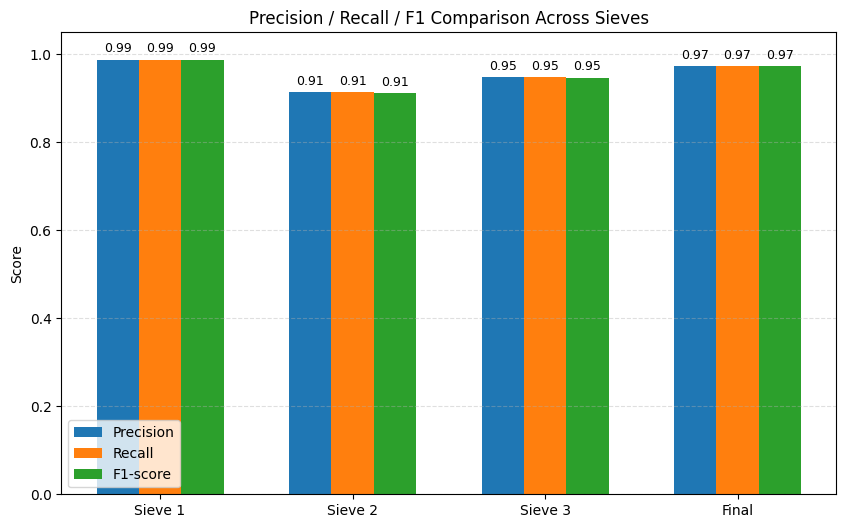

In [ ]:
# ===========================
# 10. Precision / Recall / F1 Comparison (Grouped bar chart)
# ===========================
def safe_get(m, k):
    try:
        return float(m.get(k, np.nan))
    except Exception:
        return np.nan

sieves = ["Sieve 1", "Sieve 2", "Sieve 3", "Final"]
precisions = [
    safe_get(metrics_s1, "Precision"),
    safe_get(metrics_s2, "Precision"),
    safe_get(metrics_s3, "Precision"),
    safe_get(metrics_final, "Precision"),
]
recalls = [
    safe_get(metrics_s1, "Recall"),
    safe_get(metrics_s2, "Recall"),
    safe_get(metrics_s3, "Recall"),
    safe_get(metrics_final, "Recall"),
]
f1s = [
    safe_get(metrics_s1, "F1-score"),
    safe_get(metrics_s2, "F1-score"),
    safe_get(metrics_s3, "F1-score"),
    safe_get(metrics_final, "F1-score"),
]

df_metrics = pd.DataFrame({
    "Sieve": sieves,
    "Precision": precisions,
    "Recall": recalls,
    "F1": f1s
})

x = np.arange(len(sieves))
width = 0.22

plt.figure(figsize=(10,6))
bars1 = plt.bar(x - width, df_metrics["Precision"], width, label="Precision")
bars2 = plt.bar(x,         df_metrics["Recall"],    width, label="Recall")
bars3 = plt.bar(x + width, df_metrics["F1"],        width, label="F1-score")

def annotate_bars(bars):
    for b in bars:
        h = b.get_height()
        if np.isnan(h):
            txt = "n/a"
            plt.text(b.get_x() + b.get_width()/2, 0.02, txt, ha="center", va="bottom", fontsize=9)
        else:
            plt.text(b.get_x() + b.get_width()/2, h + 0.01, f"{h:.2f}", ha="center", va="bottom", fontsize=9)

annotate_bars(bars1)
annotate_bars(bars2)
annotate_bars(bars3)

plt.xticks(x, sieves)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Precision / Recall / F1 Comparison Across Sieves")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

=== Sieve 2 - CNN ===
Accuracy: 0.9345
Precision (weighted/macro/micro): 0.9340 / 0.9253 / 0.9345
Recall    (weighted/macro/micro): 0.9345 / 0.8888 / 0.9345
F1-score  (weighted/macro/micro): 0.9337 / 0.9042 / 0.9345
MSE: 0.452643  RMSE: 0.672787

Classification Report:
              precision    recall  f1-score   support

      benign       0.95      0.96      0.96     17284
  defacement       0.94      0.98      0.96      3140
     malware       0.90      0.71      0.80      1164
    phishing       0.92      0.90      0.91     10994

    accuracy                           0.93     32582
   macro avg       0.93      0.89      0.90     32582
weighted avg       0.93      0.93      0.93     32582



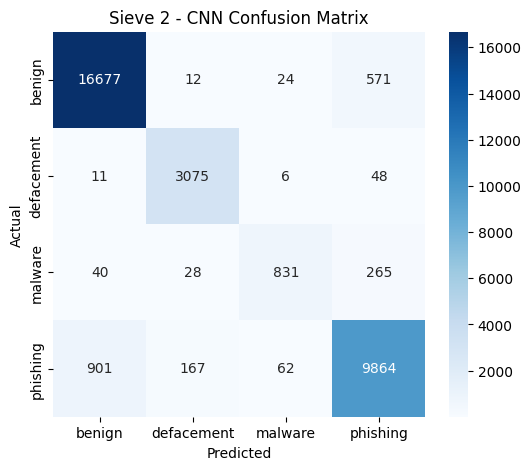

ROC-AUC (macro / OVR where applicable): 0.9865
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 120s 118ms/step

=== Sieve 2 - LSTM ===
Accuracy: 0.9048
Precision (weighted/macro/micro): 0.9046 / 0.8967 / 0.9048
Recall    (weighted/macro/micro): 0.9048 / 0.8208 / 0.9048
F1-score  (weighted/macro/micro): 0.9022 / 0.8470 / 0.9048
MSE: 0.642103  RMSE: 0.801313

Classification Report:
              precision    recall  f1-score   support

      benign       0.91      0.96      0.93     17284
  defacement       0.89      0.95      0.92      3140
     malware       0.88      0.53      0.66      1164
    phishing       0.91      0.84      0.87     10994

    accuracy                           0.90     32582
   macro avg       0.90      0.82      0.85     32582
weighted avg       0.90      0.90      0.90     32582



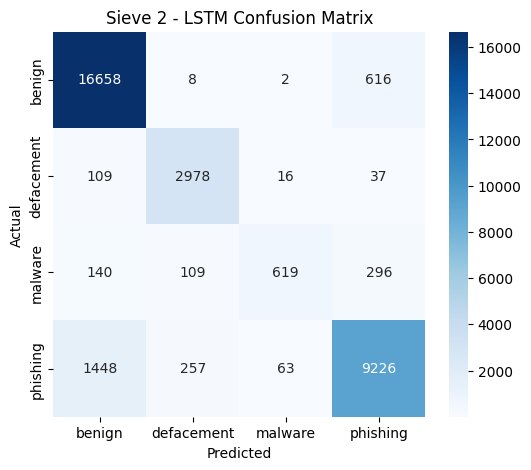

ROC-AUC (macro / OVR where applicable): 0.9782
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 230s 225ms/step

=== Sieve 2 - BiLSTM ===
Accuracy: 0.8993
Precision (weighted/macro/micro): 0.8996 / 0.8813 / 0.8993
Recall    (weighted/macro/micro): 0.8993 / 0.8266 / 0.8993
F1-score  (weighted/macro/micro): 0.8966 / 0.8448 / 0.8993
MSE: 0.688478  RMSE: 0.829746

Classification Report:
              precision    recall  f1-score   support

      benign       0.90      0.96      0.93     17284
  defacement       0.86      0.97      0.91      3140
     malware       0.85      0.56      0.68      1164
    phishing       0.91      0.81      0.86     10994

    accuracy                           0.90     32582
   macro avg       0.88      0.83      0.84     32582
weighted avg       0.90      0.90      0.90     32582



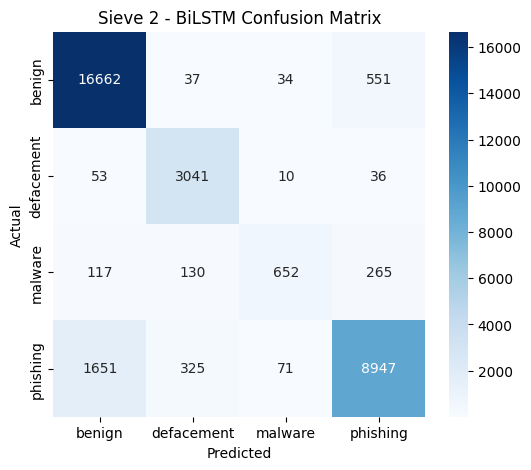

ROC-AUC (macro / OVR where applicable): 0.9778

--- Sieve 2 Models Summary ---
 Model  Accuracy  Precision (weighted)  Recall (weighted)  F1 (weighted)  ROC_AUC
   CNN  0.934473              0.933961           0.934473       0.933699 0.986508
  LSTM  0.904825              0.904597           0.904825       0.902160 0.978215
BiLSTM  0.899331              0.899620           0.899331       0.896587 0.977801


,Model,Accuracy,Precision (weighted),Recall (weighted),F1 (weighted),ROC_AUC
0,CNN,0.934473,0.933961,0.934473,0.933699,0.986508
1,LSTM,0.904825,0.904597,0.904825,0.902160,0.978215
2,BiLSTM,0.899331,0.899620,0.899331,0.896587,0.977801


In [ ]:
# ===========================
# 11. Detailed metrics & confusion matrices for each model in Sieve 2
# (CNN, LSTM, BiLSTM) — per-model evaluation on X_remaining_seq
# ===========================
from sklearn.preprocessing import label_binarize

def detailed_metrics_for_model(model, X_seq, y_true_enc, label_names, title):
    # get soft predictions (probabilities) and hard predictions
    probs = model.predict(X_seq)
    if probs.ndim == 1:
        probs = np.expand_dims(probs, axis=1)
    preds = np.argmax(probs, axis=1)

    # basic metrics
    if len(y_true_enc) == 0:
        print(f"\n=== {title} ===")
        print("No samples to evaluate for this model (empty set).")
        metrics = {
            "Accuracy": np.nan,
            "Precision_weighted": np.nan,
            "Recall_weighted": np.nan,
            "F1_weighted": np.nan,
            "Precision_macro": np.nan,
            "Recall_macro": np.nan,
            "F1_macro": np.nan,
            "Precision_micro": np.nan,
            "Recall_micro": np.nan,
            "F1_micro": np.nan,
            "MSE": np.nan,
            "RMSE": np.nan,
            "ROC_AUC": None,
            "Classification_Report": ""
        }
        return metrics, np.array([], dtype=int), np.array([])

    acc = accuracy_score(y_true_enc, preds)
    prec_weighted = precision_score(y_true_enc, preds, average="weighted", zero_division=0)
    rec_weighted = recall_score(y_true_enc, preds, average="weighted", zero_division=0)
    f1_weighted = f1_score(y_true_enc, preds, average="weighted", zero_division=0)

    prec_macro = precision_score(y_true_enc, preds, average="macro", zero_division=0)
    rec_macro = recall_score(y_true_enc, preds, average="macro", zero_division=0)
    f1_macro = f1_score(y_true_enc, preds, average="macro", zero_division=0)

    prec_micro = precision_score(y_true_enc, preds, average="micro", zero_division=0)
    rec_micro = recall_score(y_true_enc, preds, average="micro", zero_division=0)
    f1_micro = f1_score(y_true_enc, preds, average="micro", zero_division=0)

    mse = mean_squared_error(y_true_enc, preds)
    rmse = np.sqrt(mse)

    crep = classification_report(y_true_enc, preds, target_names=label_names, zero_division=0)

    # confusion matrix plot
    print(f"\n=== {title} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (weighted/macro/micro): {prec_weighted:.4f} / {prec_macro:.4f} / {prec_micro:.4f}")
    print(f"Recall    (weighted/macro/micro): {rec_weighted:.4f} / {rec_macro:.4f} / {rec_micro:.4f}")
    print(f"F1-score  (weighted/macro/micro): {f1_weighted:.4f} / {f1_macro:.4f} / {f1_micro:.4f}")
    print(f"MSE: {mse:.6f}  RMSE: {rmse:.6f}\n")
    print("Classification Report:")
    print(crep)

    plot_confusion(y_true_enc, preds, label_names, f"{title} Confusion Matrix")

    # try ROC-AUC (multiclass: one-vs-rest macro)
    roc_auc = None
    try:
        if len(label_names) == 2:
            pos_prob = probs[:, 1] if probs.shape[1] > 1 else probs.ravel()
            roc_auc = roc_auc_score(y_true_enc, pos_prob)
        else:
            y_true_bin = label_binarize(y_true_enc, classes=np.arange(len(label_names)))
            if probs.shape[1] == y_true_bin.shape[1]:
                roc_auc = roc_auc_score(y_true_bin, probs, average="macro", multi_class="ovr")
    except Exception:
        roc_auc = None

    if roc_auc is not None:
        print(f"ROC-AUC (macro / OVR where applicable): {roc_auc:.4f}")
    else:
        print("ROC-AUC: n/a (insufficient classes or probability mismatch)")

    metrics = {
        "Accuracy": acc,
        "Precision_weighted": prec_weighted,
        "Recall_weighted": rec_weighted,
        "F1_weighted": f1_weighted,
        "Precision_macro": prec_macro,
        "Recall_macro": rec_macro,
        "F1_macro": f1_macro,
        "Precision_micro": prec_micro,
        "Recall_micro": rec_micro,
        "F1_micro": f1_micro,
        "MSE": mse,
        "RMSE": rmse,
        "ROC_AUC": roc_auc,
        "Classification_Report": crep
    }

    return metrics, preds, probs

# Evaluate each model on the remaining set (Sieve 2)
metrics_s2_cnn, cnn_preds_detail, cnn_probs = detailed_metrics_for_model(
    cnn, X_remaining_seq, y_remaining_enc, le.classes_, "Sieve 2 - CNN"
)

metrics_s2_lstm, lstm_preds_detail, lstm_probs = detailed_metrics_for_model(
    lstm, X_remaining_seq, y_remaining_enc, le.classes_, "Sieve 2 - LSTM"
)

metrics_s2_bilstm, bilstm_preds_detail, bilstm_probs = detailed_metrics_for_model(
    bilstm, X_remaining_seq, y_remaining_enc, le.classes_, "Sieve 2 - BiLSTM"
)

# summary DataFrame for quick comparison (selecting key numbers)
summary_df = pd.DataFrame({
    "Model": ["CNN", "LSTM", "BiLSTM"],
    "Accuracy": [metrics_s2_cnn["Accuracy"], metrics_s2_lstm["Accuracy"], metrics_s2_bilstm["Accuracy"]],
    "Precision (weighted)": [metrics_s2_cnn["Precision_weighted"], metrics_s2_lstm["Precision_weighted"], metrics_s2_bilstm["Precision_weighted"]],
    "Recall (weighted)": [metrics_s2_cnn["Recall_weighted"], metrics_s2_lstm["Recall_weighted"], metrics_s2_bilstm["Recall_weighted"]],
    "F1 (weighted)": [metrics_s2_cnn["F1_weighted"], metrics_s2_lstm["F1_weighted"], metrics_s2_bilstm["F1_weighted"]],
    "ROC_AUC": [metrics_s2_cnn["ROC_AUC"], metrics_s2_lstm["ROC_AUC"], metrics_s2_bilstm["ROC_AUC"]],
})

print("\n--- Sieve 2 Models Summary ---")
print(summary_df.to_string(index=False))

# Optionally display DataFrame in notebook
try:
    from IPython.display import display
    display(summary_df)
except Exception:
    pass

# You can save the summary if you want:
# summary_df.to_csv("sieve2_models_summary.csv", index=False)
# plt.savefig("accuracy_comparison.png", dpi=300)


=== Final Pipeline ===
              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.99      0.99      0.99     19292
     malware       0.99      0.93      0.96      6504
    phishing       0.95      0.87      0.91     18822

    accuracy                           0.97    130239
   macro avg       0.98      0.95      0.96    130239
weighted avg       0.97      0.97      0.97    130239



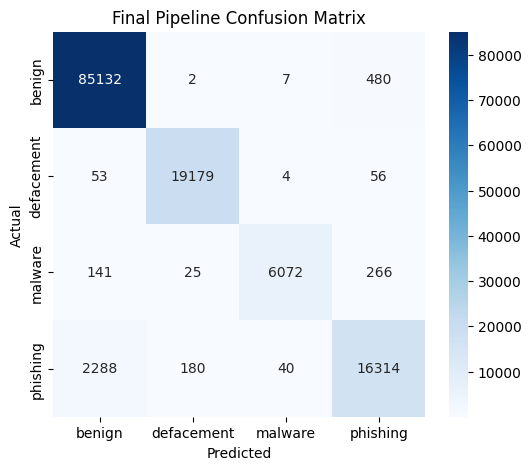

In [ ]:
metrics_final = evaluate_model(y_test_enc, final_preds, le.classes_, "Final Pipeline")

In [ ]:
# ===========================
# 11. Overall Final Metrics (Accuracy, Precision, Recall, F1)
# ===========================
print("\n===== Overall Final Pipeline Performance =====")
print(f"Accuracy : {metrics_final['Accuracy']:.4f}")
print(f"Precision: {metrics_final['Precision']:.4f}")
print(f"Recall   : {metrics_final['Recall']:.4f}")
print(f"F1-score : {metrics_final['F1-score']:.4f}")


===== Overall Final Pipeline Performance =====
Accuracy : 0.9728
Precision: 0.9726
Recall   : 0.9728
F1-score : 0.9723


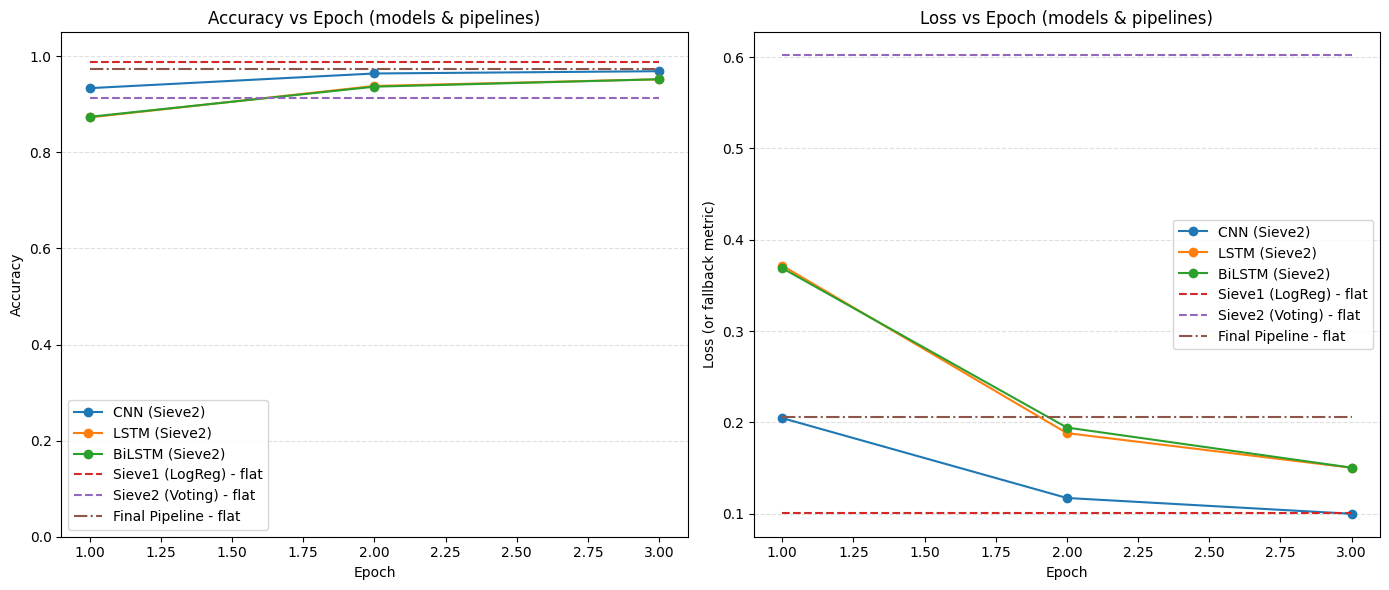


Summary (scalar values used for flat lines where applicable):
Sieve1 Accuracy: 0.9875  |  Sieve1 MSE: 0.100935
Sieve2 (Voting) Accuracy: 0.9137  |  Sieve2 MSE: 0.602020
TinyBERT (Sieve3) Accuracy: 0.9486  |  TinyBERT MSE: 0.254788
Final Pipeline Accuracy: 0.9728  |  Final MSE: 0.206067


In [ ]:
# ===========================
# Accuracy vs Epoch & Loss vs Epoch for sieves and overall
# Append this at the end of your script
# ===========================
import numpy as np
import matplotlib.pyplot as plt

# --- Helper to safely fetch history arrays (returns None if missing) ---
def get_history_list(history_obj, key):
    try:
        return list(history_obj.history[key])
    except Exception:
        return None

# Collect histories (some may be None)
cnn_acc = get_history_list(cnn_history, "accuracy")
cnn_loss = get_history_list(cnn_history, "loss")

lstm_acc = get_history_list(lstm_history, "accuracy")
lstm_loss = get_history_list(lstm_history, "loss")

bilstm_acc = get_history_list(bilstm_history, "accuracy")
bilstm_loss = get_history_list(bilstm_history, "loss")

# BERT: if you stored the return value of fit -> bert_history, use it
# If you didn't capture it earlier, try to use a variable name 'bert_history' (if present).
try:
    bert_acc = get_history_list(bert_history, "accuracy")
    bert_loss = get_history_list(bert_history, "loss")
except NameError:
    # If bert_history not available, try to detect in local scope: often fit(...) returns a History object
    bert_acc = None
    bert_loss = None

# If no bert_history captured, attempt to use 'history' returned from fit if stored differently
# (Leave as None if not available; we will still plot other items)
# --- Determine maximum epoch length among models that have histories ---
epoch_lengths = [len(x) for x in [cnn_acc, lstm_acc, bilstm_acc, bert_acc] if x is not None]
max_epochs = max(epoch_lengths) if len(epoch_lengths) > 0 else 1
epochs = np.arange(1, max_epochs + 1)

# --- For non-epoch models (Sieve1, Voting, Final) we will create flat lines across epochs ---
def flat_line_for_metric(value, length):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return np.array([np.nan] * length)
    return np.array([float(value)] * length)

# Get scalar metrics (already computed)
acc_s1_scalar = metrics_s1.get("Accuracy") if isinstance(metrics_s1, dict) else np.nan
acc_s2_scalar = metrics_s2.get("Accuracy") if isinstance(metrics_s2, dict) else np.nan
acc_s3_scalar = metrics_s3.get("Accuracy") if isinstance(metrics_s3, dict) else np.nan
acc_final_scalar = metrics_final.get("Accuracy") if isinstance(metrics_final, dict) else np.nan

mse_s1 = metrics_s1.get("MSE") if isinstance(metrics_s1, dict) else np.nan
mse_s2 = metrics_s2.get("MSE") if isinstance(metrics_s2, dict) else np.nan
mse_s3 = metrics_s3.get("MSE") if isinstance(metrics_s3, dict) else np.nan
mse_final = metrics_final.get("MSE") if isinstance(metrics_final, dict) else np.nan

# --- Build arrays for accuracy plotting ---
# Start with model histories (pad/truncate to max_epochs)
def pad_or_truncate(arr, length):
    if arr is None:
        return None
    arr = np.array(arr, dtype=float)
    if len(arr) >= length:
        return arr[:length]
    else:
        # pad with last value
        pad_vals = np.full(length - len(arr), arr[-1])
        return np.concatenate([arr, pad_vals])

cnn_acc_plot = pad_or_truncate(cnn_acc, max_epochs)
lstm_acc_plot = pad_or_truncate(lstm_acc, max_epochs)
bilstm_acc_plot = pad_or_truncate(bilstm_acc, max_epochs)
bert_acc_plot = pad_or_truncate(bert_acc, max_epochs)

# Flat lines for sieves / overall
s1_acc_plot = flat_line_for_metric(acc_s1_scalar, max_epochs)
s2_acc_plot = flat_line_for_metric(acc_s2_scalar, max_epochs)
s3_acc_plot = flat_line_for_metric(acc_s3_scalar, max_epochs)  # tinybert final acc as flat if needed
final_acc_plot = flat_line_for_metric(acc_final_scalar, max_epochs)

# --- Build arrays for loss plotting ---
# For models with history, use their reported 'loss'. Otherwise create flat loss from MSE or (1-accuracy)
cnn_loss_plot = pad_or_truncate(cnn_loss, max_epochs)
lstm_loss_plot = pad_or_truncate(lstm_loss, max_epochs)
bilstm_loss_plot = pad_or_truncate(bilstm_loss, max_epochs)
bert_loss_plot = pad_or_truncate(bert_loss, max_epochs)

def fallback_loss_from_mse_or_acc(mse, acc, length):
    if mse is not None and not (np.isnan(mse)):
        return np.array([float(mse)] * length)
    if acc is not None and not (np.isnan(acc)):
        return np.array([max(0.0, 1.0 - float(acc))] * length)
    return np.array([np.nan] * length)

s1_loss_plot = fallback_loss_from_mse_or_acc(mse_s1, acc_s1_scalar, max_epochs)
s2_loss_plot = fallback_loss_from_mse_or_acc(mse_s2, acc_s2_scalar, max_epochs)
s3_loss_plot = fallback_loss_from_mse_or_acc(mse_s3, acc_s3_scalar, max_epochs)
final_loss_plot = fallback_loss_from_mse_or_acc(mse_final, acc_final_scalar, max_epochs)

# If any model history is None, it won't be plotted — but flat lines will still show Sieve1/Sieve2/Final.
# --- Now plot Accuracy vs Epoch ---
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plotted = False

if cnn_acc_plot is not None:
    plt.plot(epochs, cnn_acc_plot, label="CNN (Sieve2)", marker='o')
    plotted = True
if lstm_acc_plot is not None:
    plt.plot(epochs, lstm_acc_plot, label="LSTM (Sieve2)", marker='o'); plotted = True
if bilstm_acc_plot is not None:
    plt.plot(epochs, bilstm_acc_plot, label="BiLSTM (Sieve2)", marker='o'); plotted = True
if bert_acc_plot is not None:
    plt.plot(epochs, bert_acc_plot, label="TinyBERT (Sieve3)", marker='o'); plotted = True

# Always plot flat lines for Sieve1, Voting (Sieve2 overall voting accuracy) and Final pipeline
plt.plot(epochs, s1_acc_plot, label="Sieve1 (LogReg) - flat", linestyle='--')
plt.plot(epochs, s2_acc_plot, label="Sieve2 (Voting) - flat", linestyle='--')
plt.plot(epochs, final_acc_plot, label="Final Pipeline - flat", linestyle='-.')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch (models & pipelines)")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

# --- Loss vs Epoch ---
plt.subplot(1,2,2)
if cnn_loss_plot is not None:
    plt.plot(epochs, cnn_loss_plot, label="CNN (Sieve2)", marker='o')
if lstm_loss_plot is not None:
    plt.plot(epochs, lstm_loss_plot, label="LSTM (Sieve2)", marker='o')
if bilstm_loss_plot is not None:
    plt.plot(epochs, bilstm_loss_plot, label="BiLSTM (Sieve2)", marker='o')
if bert_loss_plot is not None:
    plt.plot(epochs, bert_loss_plot, label="TinyBERT (Sieve3)", marker='o')

# plot flat losses for Sieve1 / Sieve2 / Final
plt.plot(epochs, s1_loss_plot, label="Sieve1 (LogReg) - flat", linestyle='--')
plt.plot(epochs, s2_loss_plot, label="Sieve2 (Voting) - flat", linestyle='--')
plt.plot(epochs, final_loss_plot, label="Final Pipeline - flat", linestyle='-.')
plt.xlabel("Epoch")
plt.ylabel("Loss (or fallback metric)")
plt.title("Loss vs Epoch (models & pipelines)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# --- Small textual summary printed below the plots ---
print("\nSummary (scalar values used for flat lines where applicable):")
print(f"Sieve1 Accuracy: {acc_s1_scalar:.4f}  |  Sieve1 MSE: {mse_s1:.6f}")
print(f"Sieve2 (Voting) Accuracy: {acc_s2_scalar:.4f}  |  Sieve2 MSE: {mse_s2:.6f}")
print(f"TinyBERT (Sieve3) Accuracy: {acc_s3_scalar:.4f}  |  TinyBERT MSE: {mse_s3:.6f}")
print(f"Final Pipeline Accuracy: {acc_final_scalar:.4f}  |  Final MSE: {mse_final:.6f}")

In [ ]:
# ===========================
# 12. MSE and RMSE Summary
# ===========================
print("\n===== MSE / RMSE Summary Across Sieves and Final Pipeline =====")
print(f"Sieve 1 (LogReg)   -> MSE: {metrics_s1['MSE']:.6f}, RMSE: {metrics_s1['RMSE']:.6f}")
print(f"Sieve 2 (Voting)   -> MSE: {metrics_s2['MSE']:.6f}, RMSE: {metrics_s2['RMSE']:.6f}")
print(f"Sieve 3 (TinyBERT) -> MSE: {metrics_s3['MSE']:.6f}, RMSE: {metrics_s3['RMSE']:.6f}")
print(f"Final Pipeline     -> MSE: {metrics_final['MSE']:.6f}, RMSE: {metrics_final['RMSE']:.6f}")


===== MSE / RMSE Summary Across Sieves and Final Pipeline =====
Sieve 1 (LogReg)   -> MSE: 0.100935, RMSE: 0.317703
Sieve 2 (Voting)   -> MSE: 0.602020, RMSE: 0.775899
Sieve 3 (TinyBERT) -> MSE: 0.254788, RMSE: 0.504765
Final Pipeline     -> MSE: 0.206067, RMSE: 0.453946


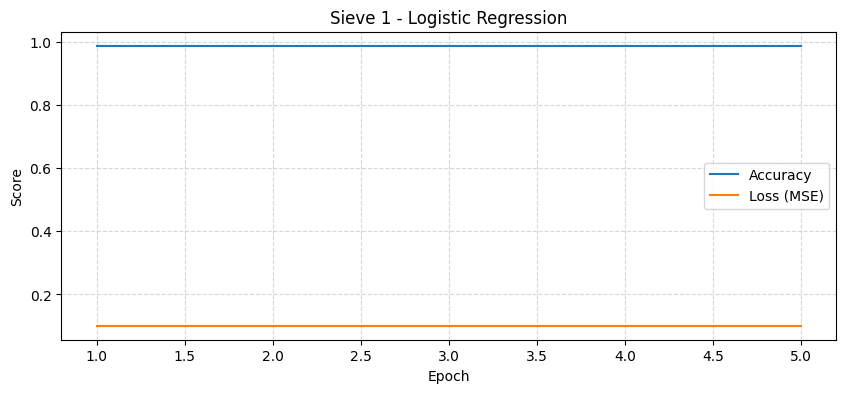

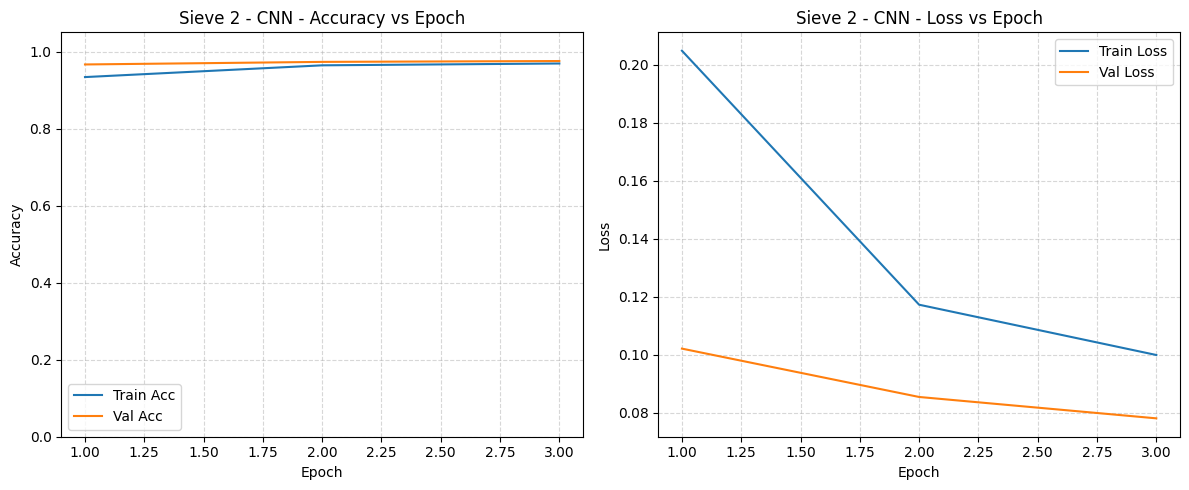

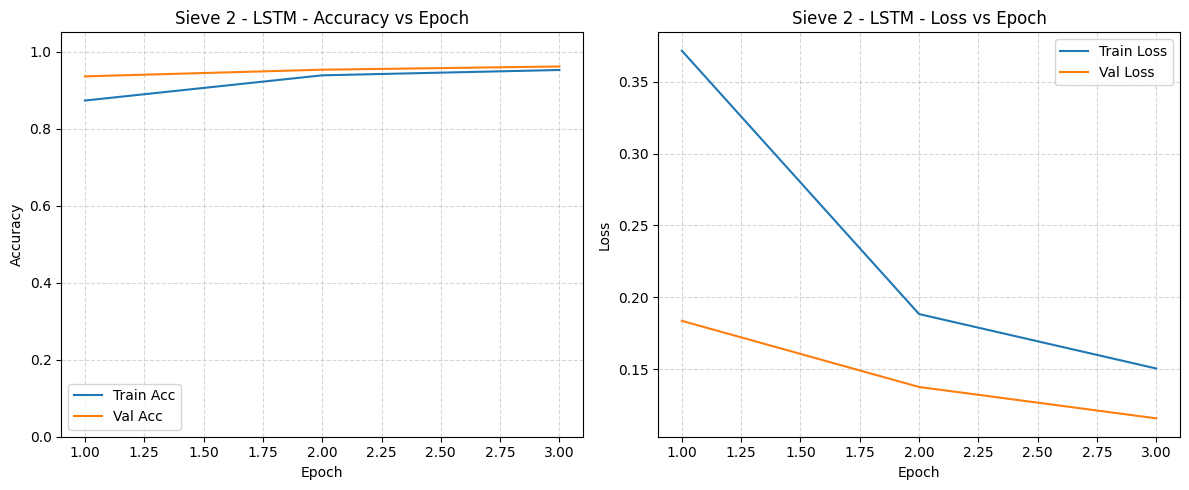

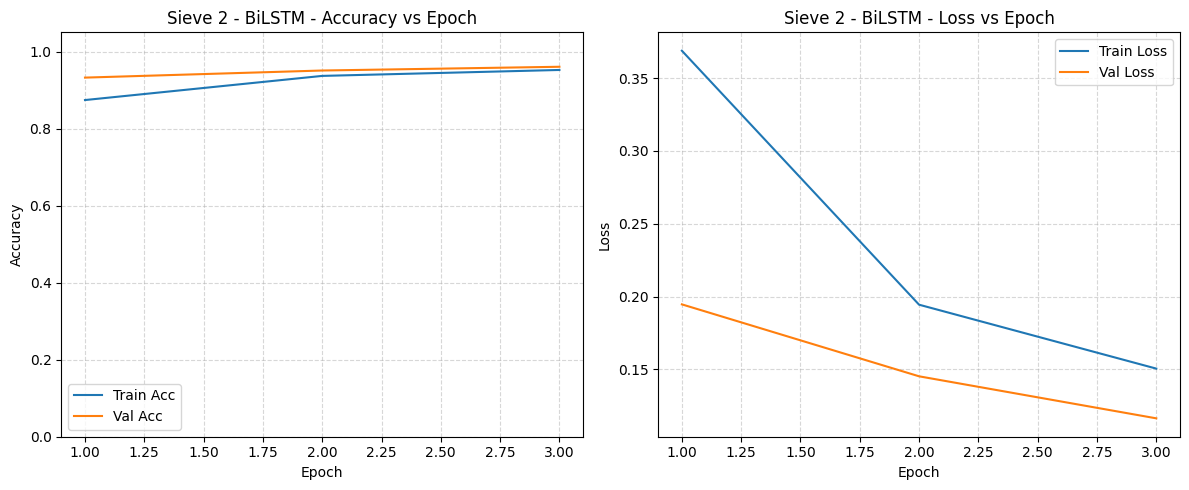

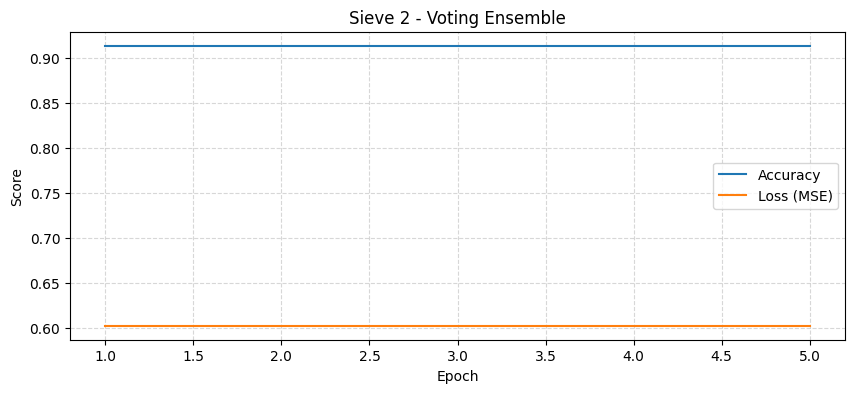

TinyBERT history not available, showing flat performance instead.


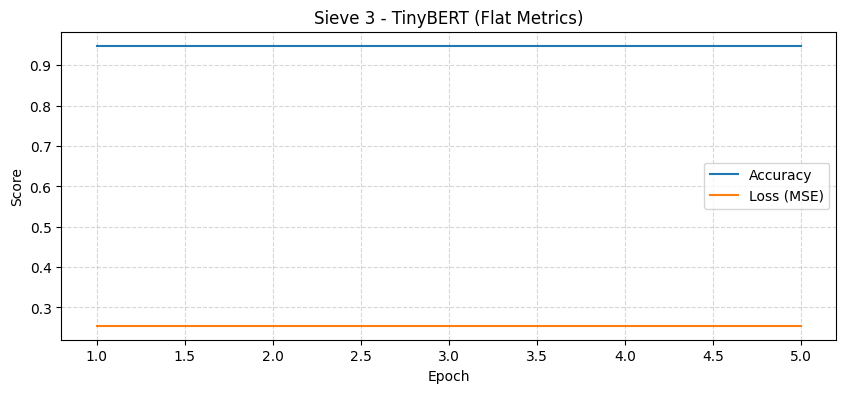

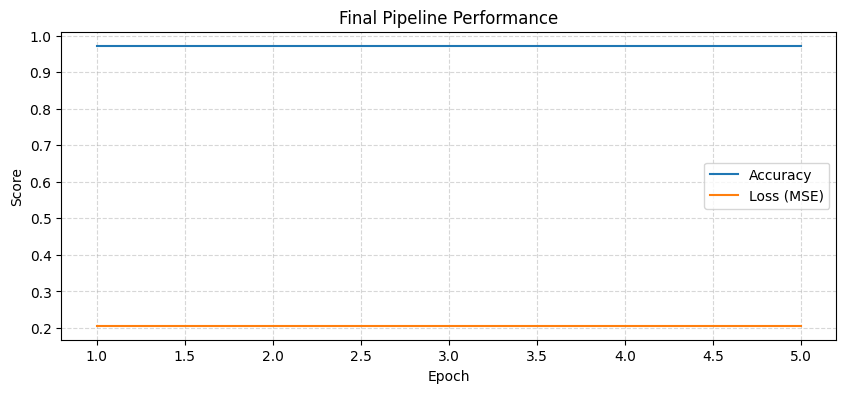

In [ ]:
# ===========================
# Separate Accuracy vs Epoch / Loss vs Epoch Plots for Each Sieve & Final
# ===========================

def plot_history(acc, loss, val_acc=None, val_loss=None, title="Model"):
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label="Train Acc")
    if val_acc is not None:
        plt.plot(epochs, val_acc, label="Val Acc")
    plt.title(f"{title} - Accuracy vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label="Train Loss")
    if val_loss is not None:
        plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"{title} - Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


# --- Sieve 1: Logistic Regression (flat line, no epochs) ---
plt.figure(figsize=(10,4))
epochs = range(1, 6)  # fake 5 epochs for visualization
plt.plot(epochs, [metrics_s1["Accuracy"]]*5, label="Accuracy")
plt.plot(epochs, [metrics_s1["MSE"]]*5, label="Loss (MSE)")
plt.title("Sieve 1 - Logistic Regression")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


# --- Sieve 2 Models: CNN, LSTM, BiLSTM (real histories) ---
plot_history(
    cnn_history.history["accuracy"],
    cnn_history.history["loss"],
    cnn_history.history.get("val_accuracy"),
    cnn_history.history.get("val_loss"),
    "Sieve 2 - CNN"
)

plot_history(
    lstm_history.history["accuracy"],
    lstm_history.history["loss"],
    lstm_history.history.get("val_accuracy"),
    lstm_history.history.get("val_loss"),
    "Sieve 2 - LSTM"
)

plot_history(
    bilstm_history.history["accuracy"],
    bilstm_history.history["loss"],
    bilstm_history.history.get("val_accuracy"),
    bilstm_history.history.get("val_loss"),
    "Sieve 2 - BiLSTM"
)

# Voting has no history → flat line
plt.figure(figsize=(10,4))
epochs = range(1, 6)
plt.plot(epochs, [metrics_s2["Accuracy"]]*5, label="Accuracy")
plt.plot(epochs, [metrics_s2["MSE"]]*5, label="Loss (MSE)")
plt.title("Sieve 2 - Voting Ensemble")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


# --- Sieve 3: TinyBERT (if history captured) ---
try:
    plot_history(
        bert_history.history["accuracy"],
        bert_history.history["loss"],
        bert_history.history.get("val_accuracy"),
        bert_history.history.get("val_loss"),
        "Sieve 3 - TinyBERT"
    )
except Exception:
    print("TinyBERT history not available, showing flat performance instead.")
    plt.figure(figsize=(10,4))
    epochs = range(1, 6)
    plt.plot(epochs, [metrics_s3["Accuracy"]]*5, label="Accuracy")
    plt.plot(epochs, [metrics_s3["MSE"]]*5, label="Loss (MSE)")
    plt.title("Sieve 3 - TinyBERT (Flat Metrics)")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


# --- Final Pipeline (flat line) ---
plt.figure(figsize=(10,4))
epochs = range(1, 6)
plt.plot(epochs, [metrics_final["Accuracy"]]*5, label="Accuracy")
plt.plot(epochs, [metrics_final["MSE"]]*5, label="Loss (MSE)")
plt.title("Final Pipeline Performance")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

=== Sieve 2 - CNN ===
              precision    recall  f1-score   support

      benign       0.95      0.96      0.96     17284
  defacement       0.94      0.98      0.96      3140
     malware       0.90      0.71      0.80      1164
    phishing       0.92      0.90      0.91     10994

    accuracy                           0.93     32582
   macro avg       0.93      0.89      0.90     32582
weighted avg       0.93      0.93      0.93     32582



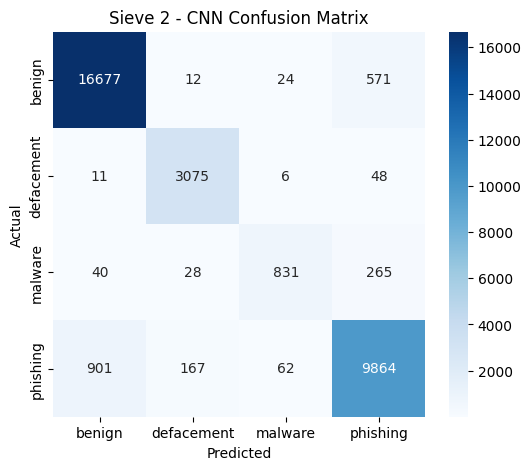

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 118s 115ms/step

=== Sieve 2 - LSTM ===
              precision    recall  f1-score   support

      benign       0.91      0.96      0.93     17284
  defacement       0.89      0.95      0.92      3140
     malware       0.88      0.53      0.66      1164
    phishing       0.91      0.84      0.87     10994

    accuracy                           0.90     32582
   macro avg       0.90      0.82      0.85     32582
weighted avg       0.90      0.90      0.90     32582



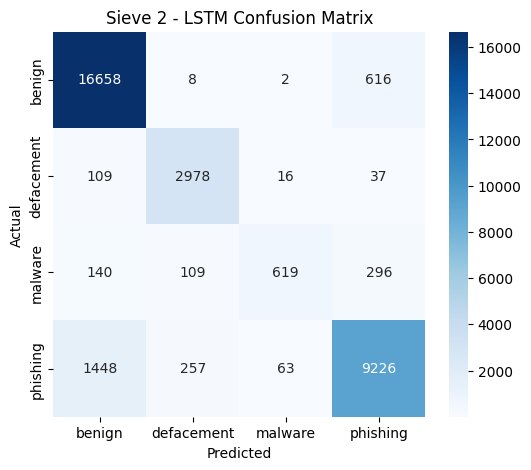

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 229s 225ms/step

=== Sieve 2 - BiLSTM ===
              precision    recall  f1-score   support

      benign       0.90      0.96      0.93     17284
  defacement       0.86      0.97      0.91      3140
     malware       0.85      0.56      0.68      1164
    phishing       0.91      0.81      0.86     10994

    accuracy                           0.90     32582
   macro avg       0.88      0.83      0.84     32582
weighted avg       0.90      0.90      0.90     32582



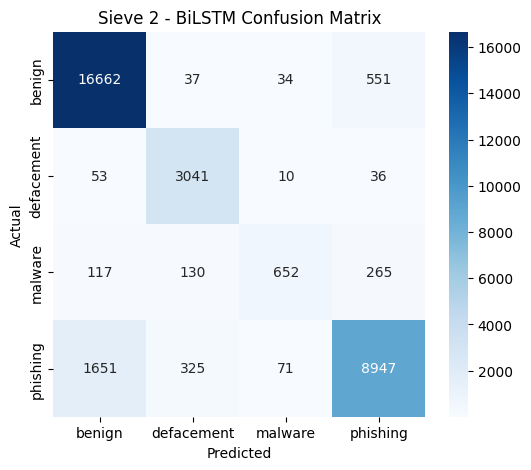


===== Sieve 2 Individual Models - Summary =====

CNN Performance:
Accuracy : 0.9345
Precision: 0.9340
Recall   : 0.9345
F1-score : 0.9337
MSE      : 0.452643
RMSE     : 0.672787

LSTM Performance:
Accuracy : 0.9048
Precision: 0.9046
Recall   : 0.9048
F1-score : 0.9022
MSE      : 0.642103
RMSE     : 0.801313

BiLSTM Performance:
Accuracy : 0.8993
Precision: 0.8996
Recall   : 0.8993
F1-score : 0.8966
MSE      : 0.688478
RMSE     : 0.829746


In [ ]:
# ===========================
# Evaluate Sieve 2 Individual Models (CNN, LSTM, BiLSTM)
# ===========================

# CNN evaluation
cnn_preds_ind = np.argmax(cnn.predict(X_remaining_seq), axis=1)
metrics_cnn = evaluate_model(
    y_remaining_enc, cnn_preds_ind, le.classes_, "Sieve 2 - CNN"
)

# LSTM evaluation
lstm_preds_ind = np.argmax(lstm.predict(X_remaining_seq), axis=1)
metrics_lstm = evaluate_model(
    y_remaining_enc, lstm_preds_ind, le.classes_, "Sieve 2 - LSTM"
)

# BiLSTM evaluation
bilstm_preds_ind = np.argmax(bilstm.predict(X_remaining_seq), axis=1)
metrics_bilstm = evaluate_model(
    y_remaining_enc, bilstm_preds_ind, le.classes_, "Sieve 2 - BiLSTM"
)

# Print summary of all three models
print("\n===== Sieve 2 Individual Models - Summary =====")
for name, metrics in zip(
    ["CNN", "LSTM", "BiLSTM"],
    [metrics_cnn, metrics_lstm, metrics_bilstm]
):
    print(f"\n{name} Performance:")
    print(f"Accuracy : {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall   : {metrics['Recall']:.4f}")
    print(f"F1-score : {metrics['F1-score']:.4f}")
    print(f"MSE      : {metrics['MSE']:.6f}")
    print(f"RMSE     : {metrics['RMSE']:.6f}")